In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

/scratch/cz2064/envs/dl4med/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
!pwd

/scratch/cz2064/myjupyter/Time_Series/notebook


In [3]:
metadata_path = '/scratch/cz2064/myjupyter/Time_Series/Data/metadata/list_test_all2.txt'
metadata_train = pd.read_csv(metadata_path,sep=' ',header=None)
metadata_train.columns = ['True or False' ,'sample 1','sample 2']
metadata_train

,True or False,sample 1,sample 2
0,1,id10001/Y8hIVOBuels/00001.wav,id10001/1zcIwhmdeo4/00001.wav
1,0,id10001/Y8hIVOBuels/00001.wav,id10943/vNCVj7yLWPU/00005.wav
2,1,id10001/Y8hIVOBuels/00001.wav,id10001/7w0IBEWc9Qw/00004.wav
3,0,id10001/Y8hIVOBuels/00001.wav,id10999/G5R2-Hl7YX8/00008.wav
4,1,id10001/Y8hIVOBuels/00002.wav,id10001/7w0IBEWc9Qw/00002.wav
...,...,...,...
579813,0,id11251/5-6lI5JQtb8/00004.wav,id10583/rrPb_EgwUD0/00021.wav
579814,1,id11251/5-6lI5JQtb8/00005.wav,id11251/7GtZpUtReJ8/00004.wav
579815,0,id11251/5-6lI5JQtb8/00005.wav,id10786/uQUacPIpU-k/00003.wav
579816,1,id11251/5-6lI5JQtb8/00005.wav,id11251/XHCSVYEZvlM/00001.wav


In [4]:
metadata_path = '/scratch/cz2064/myjupyter/Time_Series/Data/metadata/veri_test2.txt'
metadata_test = pd.read_csv(metadata_path,sep=' ',header=None)
metadata_test.columns = ['True or False' ,'sample 1','sample 2']
metadata_test

,True or False,sample 1,sample 2
0,1,id10270/x6uYqmx31kE/00001.wav,id10270/8jEAjG6SegY/00008.wav
1,0,id10270/x6uYqmx31kE/00001.wav,id10300/ize_eiCFEg0/00003.wav
2,1,id10270/x6uYqmx31kE/00001.wav,id10270/GWXujl-xAVM/00017.wav
3,0,id10270/x6uYqmx31kE/00001.wav,id10273/0OCW1HUxZyg/00001.wav
4,1,id10270/x6uYqmx31kE/00001.wav,id10270/8jEAjG6SegY/00022.wav
...,...,...,...
37606,0,id10309/0cYFdtyWVds/00005.wav,id10302/K2_D_tFdAgY/00036.wav
37607,1,id10309/0cYFdtyWVds/00005.wav,id10309/0b1inHMAr6o/00010.wav
37608,0,id10309/0cYFdtyWVds/00005.wav,id10289/8l5ZnDf-FUA/00012.wav
37609,1,id10309/0cYFdtyWVds/00005.wav,id10309/rxnN8thYzEQ/00017.wav


In [5]:
idx = np.arange(len(metadata_train))
np.random.seed(0)
np.random.shuffle(idx)
val_size = int(len(metadata_train)/50) # 2% validation
train_size = len(metadata_train) - val_size
train_idx = idx[:train_size]
val_idx = idx[train_size:]
train_df = metadata_train.iloc[train_idx,:]
val_df = metadata_train.iloc[val_idx,:]

In [6]:
#train_df.to_csv('train.csv', index = False)
#val_df.to_csv('val.csv', index = False)
#metadata_test.to_csv('test.csv', index = False)

In [7]:
train_df

,True or False,sample 1,sample 2
89088,0,id10200/kMyh9kSFhL8/00036.wav,id10816/vMxaVSlxVdE/00003.wav
311455,0,id10689/Tm_lH_mQNmw/00012.wav,id10933/TDgOewRbqzM/00004.wav
489634,0,id11066/WQKZecmCJoU/00005.wav,id10616/FBCol-ofTg0/00009.wav
135241,1,id10300/mYSVs_d1aMQ/00012.wav,id10300/8EDKH42GZ1o/00016.wav
166302,0,id10362/ropDvVF4weI/00004.wav,id10022/S_Mr5l8yRiU/00002.wav
...,...,...,...
122638,1,id10273/ZpPPaMazpf0/00013.wav,id10273/prqT1CcDqMc/00015.wav
405731,0,id10897/aynCHKSFutA/00001.wav,id10540/x056ioqqn8A/00005.wav
453384,1,id10988/Wf3WuBm1F9s/00024.wav,id10988/X8sCFY7ztnw/00002.wav
84598,1,id10191/SpfgFnF6Rzk/00001.wav,id10191/cPHLj4oKxIs/00005.wav


In [8]:
val_df

,True or False,sample 1,sample 2
222585,0,id10484/uZlbqPBFXd4/00006.wav,id11013/UUxkxsxOWk4/00003.wav
556690,1,id11202/2FgveNLCJHg/00008.wav,id11202/2FgveNLCJHg/00005.wav
234532,1,id10513/FntCHIAuebw/00006.wav,id10513/N_a_5fHe-No/00002.wav
343386,0,id10757/BdwRqo2bWds/00002.wav,id10961/QU3dX-KgH9U/00001.wav
459008,0,id10999/G5R2-Hl7YX8/00018.wav,id10996/EFfIIkfACx8/00035.wav
...,...,...,...
359783,1,id10790/3uNEf8wV728/00075.wav,id10790/ggu0btpp6qU/00002.wav
152315,1,id10340/EBvnfqIOHwE/00010.wav,id10340/EBvnfqIOHwE/00014.wav
117952,1,id10260/DOsLMpphQ_M/00054.wav,id10260/xw9f4hGyXyQ/00009.wav
435829,0,id10953/uCrnjDq2_vE/00001.wav,id11081/K2-NBw__gOQ/00011.wav


In [9]:
sample_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/id10270/x6uYqmx31kE/00001.wav'

In [10]:
sample_path_2 = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/id10309/0cYFdtyWVds/00005.wav'

In [11]:
a,b = torchaudio.load(sample_path)

In [12]:
a2,b2 = torchaudio.load(sample_path_2)

In [13]:
a.size()

torch.Size([1, 90881])

In [14]:
b

16000

In [15]:
for i in train_df.index[:10]:
    sample = train_df.loc[i,'sample 1']
    sample_1_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/'+sample
    a,b = torchaudio.load(sample_1_path)
    print(a.size(1))

76161
114561
182401
165121
81921
90241
72961
76801
71681
135681


In [16]:
256*256

65536

In [17]:
def random_sampling_and_normalization(sample,sampling_length=256*256,padding=10):
    length = sample.size(1)
    if length<sampling_length:
        pad = int((sampling_length-length)/2)
        sample = torch.cat((torch.zeros((1,pad)),sample,torch.zeros((1,pad))),-1)
    sample = torch.cat((torch.zeros((1,padding)),sample,torch.zeros((1,padding))),-1)
    length = sample.size(1)
    random_num = np.random.randint(low=0, high=(length-sampling_length-1))
    sample = sample[:,random_num:random_num+sampling_length]
    
    #normalization
    #channel=（channel-mean）/std
    mean = torch.mean(sample)
    std = torch.std(sample)
    sample = (sample-mean)/std
    return sample

In [18]:
def center_sampling_and_normalization(sample,sampling_length=256*256):
    length = sample.size(1)
    if length<sampling_length:
        pad = int(sampling_length-length)
        sample = torch.cat((sample,torch.zeros((1,pad))),-1)
    sample = sample[:,:sampling_length]
    #normalization
    #channel=（channel-mean）/std
    mean = torch.mean(sample)
    std = torch.std(sample)
    sample = (sample-mean)/std
    return sample

In [19]:
def train_transform(sample,padding=200):
    pad_num = np.random.randint(padding)
    sample = torch.cat((torch.zeros((1,pad_num)),sample),-1)
    specgram = torchaudio.transforms.Spectrogram()(sample).log2()[0,:,:]
    sub_specgram_num = int(np.ceil(specgram.size(1)/specgram.size(0)))
    target_specgram = torch.zeros(specgram.size(0),sub_specgram_num*specgram.size(0))
    target_specgram[:,:specgram.size(1)] = specgram
    target_specgram = torch.stack(target_specgram.chunk(sub_specgram_num,dim=-1),dim=0)
    target_specgram_new = torch.zeros([target_specgram.size(0),224,224],dtype=torch.float)
    for i in range(target_specgram.size(0)):
        target_specgram_i = target_specgram[i].unsqueeze(0)
        target_specgram_i = transforms.RandomCrop(224, padding=24)(target_specgram_i)
        target_specgram_i = transforms.Normalize((0.5),(0.5))(target_specgram_i)
        target_specgram_i = target_specgram_i.squeeze(0)
        target_specgram_new[i] = target_specgram_i
    return target_specgram_new

In [20]:
target_specgram = train_transform(a)

/scratch/cz2064/envs/dl4med/lib/python3.6/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603728993639/work/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/scratch/cz2064/envs/dl4med/lib/python3.6/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603728993639/work/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


In [21]:
target_specgram.size()

torch.Size([4, 224, 224])

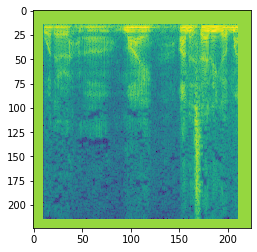

In [22]:
plt.imshow(target_specgram[0].numpy())

In [23]:
def test_transform(sample):
    specgram = torchaudio.transforms.Spectrogram()(sample).log2()[0,:,:]
    sub_specgram_num = int(np.ceil(specgram.size(1)/specgram.size(0)))
    target_specgram = torch.zeros(specgram.size(0),sub_specgram_num*specgram.size(0))
    target_specgram[:,:specgram.size(1)] = specgram
    target_specgram = torch.stack(target_specgram.chunk(sub_specgram_num,dim=-1),dim=0)
    target_specgram_new = torch.zeros([target_specgram.size(0),224,224],dtype=torch.float)
    for i in range(target_specgram.size(0)):
        target_specgram_i = target_specgram[i].unsqueeze(0)
        target_specgram_i = transforms.Pad(24)(target_specgram_i)
        target_specgram_i = transforms.CenterCrop(224)(target_specgram_i)
        target_specgram_i = transforms.Normalize((0.5),(0.5))(target_specgram_i)
        target_specgram_i = target_specgram_i.squeeze(0)
        target_specgram_new[i] = target_specgram_i
    return target_specgram_new

In [24]:
class my_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        sample_1_name = self.df.iloc[idx]['sample 1']
        sample_1_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/'+sample_1_name
        sample_1,_ = torchaudio.load(sample_1_path)
        
        sample_2_name = self.df.iloc[idx]['sample 2']
        sample_2_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/'+sample_2_name
        sample_2,_ = torchaudio.load(sample_2_path)
        
        if self.train:
            sample_1_tensor = train_transform(sample_1)
            sample_2_tensor = train_transform(sample_2)
        else:
            sample_1_tensor = test_transform(sample_1)
            sample_2_tensor = test_transform(sample_2)
            
            
        label = self.df.loc[idx,'True or False']
        #label = torch.tensor(label, dtype=torch.long)
        
        #sample = {'x1': sample_1_tensor, 'x2': sample_2_tensor, 'y': label}
        sample = (sample_1_tensor, sample_2_tensor, label)
        
        return sample

def pad_collate(batch):
    (xx1,xx2, yy) = zip(*batch)
    x1_lens = [len(x) for x in xx1]
    x2_lens = [len(x) for x in xx2]
    x1_max_len = np.max(x1_lens)
    x2_max_len = np.max(x2_lens)
    
    xx1_new = torch.zeros([len(xx1),x1_max_len,xx1[0].size(1),xx1[0].size(2)],dtype=torch.float)
    for i in range(len(xx1)):
        x1 = xx1[i]
        new_x1 = torch.zeros(x1_max_len,x1.size(1),x1.size(2))
        new_x1[:x1.size(0),:,:] = x1
        xx1_new[i,:,:,:] = new_x1
    
    xx2_new = torch.zeros([len(xx2),x2_max_len,xx2[0].size(1),xx2[0].size(2)],dtype=torch.float)
    for i in range(len(xx2)):
        x2 = xx2[i]
        new_x2 = torch.zeros(x2_max_len,x2.size(1),x2.size(2))
        new_x2[:x2.size(0),:,:] = x2
        xx2_new[i,:,:,:] = new_x2

    yy_new = torch.tensor(yy, dtype=torch.long)
    return (xx1_new,xx2_new,yy_new)

In [25]:
train_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/train.csv'
val_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/val.csv'
test_df_path = '/scratch/cz2064/myjupyter/Time_Series/notebook/test.csv'
BATCH_SIZE = 8
train_sampler = torch.utils.data.sampler.RandomSampler(my_dataset(train_df_path,train = True)\
                                                       ,num_samples=50000,replacement=True)
train_loader = DataLoader(my_dataset(train_df_path,train = True), batch_size=BATCH_SIZE, \
                          sampler = train_sampler,num_workers=16,collate_fn = pad_collate)

val_loader = DataLoader(my_dataset(val_df_path), batch_size=BATCH_SIZE, shuffle=True,\
                        num_workers=16,collate_fn = pad_collate)

test_loader = DataLoader(my_dataset(test_df_path), batch_size=1, shuffle=True)

In [26]:
iter_ = iter(train_loader)

In [27]:
next(iter_)[0].size()

torch.Size([8, 6, 224, 224])

In [28]:
a2.size()

torch.Size([1, 103041])

In [29]:
specgram = torchaudio.transforms.Spectrogram()(random_sampling_and_normalization(a2))

In [30]:
torch.min(specgram)

tensor(3.6243e-09)

In [31]:
s = torch.cat((torch.zeros((1,100000)),a2,torch.zeros((1,100000))),-1)
specgram = torchaudio.transforms.Spectrogram()(s)

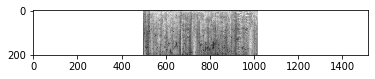

In [32]:
plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap='gray')

In [33]:
specgram.size()

torch.Size([1, 201, 1516])

In [34]:
specgram.size()

torch.Size([1, 201, 1516])

In [35]:
specgram = torchaudio.transforms.Spectrogram()(a2)

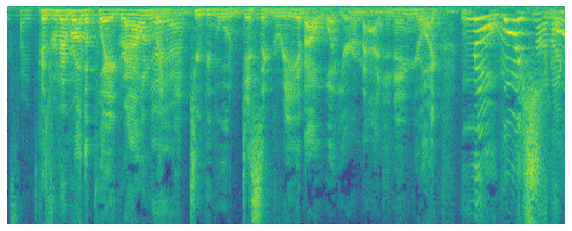

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(specgram.log2()[0,:,:].numpy());
plt.axis('off');

## Mean and Std 

In [35]:
train_df

,True or False,sample 1,sample 2
89088,0,id10200/kMyh9kSFhL8/00036.wav,id10816/vMxaVSlxVdE/00003.wav
311455,0,id10689/Tm_lH_mQNmw/00012.wav,id10933/TDgOewRbqzM/00004.wav
489634,0,id11066/WQKZecmCJoU/00005.wav,id10616/FBCol-ofTg0/00009.wav
135241,1,id10300/mYSVs_d1aMQ/00012.wav,id10300/8EDKH42GZ1o/00016.wav
166302,0,id10362/ropDvVF4weI/00004.wav,id10022/S_Mr5l8yRiU/00002.wav
...,...,...,...
122638,1,id10273/ZpPPaMazpf0/00013.wav,id10273/prqT1CcDqMc/00015.wav
405731,0,id10897/aynCHKSFutA/00001.wav,id10540/x056ioqqn8A/00005.wav
453384,1,id10988/Wf3WuBm1F9s/00024.wav,id10988/X8sCFY7ztnw/00002.wav
84598,1,id10191/SpfgFnF6Rzk/00001.wav,id10191/cPHLj4oKxIs/00005.wav


In [57]:
mean_list = []
std_list = []
for i in train_df.index[:1000]:
    sample_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/' + train_df.loc[i,'sample 1']
    sample,_ = torchaudio.load(sample_path)
    mean = float(torch.mean(sample))
    std = float(torch.std(sample))
    mean_list.append(mean)
    std_list.append(std)
    
    sample_path = '/scratch/cz2064/myjupyter/Time_Series/Data/data_VoxCeleb/wav/' + train_df.loc[i,'sample 2']
    sample,_ = torchaudio.load(sample_path)
    mean = float(torch.mean(sample))
    std = float(torch.std(sample))
    mean_list.append(mean)
    std_list.append(std)

In [58]:
np.mean(mean_list)

1.991931675755221e-05

In [59]:
np.mean(std_list)

0.0529395616754191

In [60]:
!pwd

/scratch/cz2064/myjupyter/Time_Series/notebook
